In [19]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
import seaborn as sns
from itertools import product
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
#from codes.regression import Regression

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [20]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

# A: whole RBS sequence (len: 29)
# B: extracted 20-base RBS seqeunce (A[7:27], len: 20), training features
# C: TIR labels
# D: the design part RBS (B[7:13], len: 6) 

#Path = '../../data/First_round_results/Results - First Plate 3 reps.csv'
Path = '../../data/firstRound_Microplate_normFalse_formatSeq_logTrue.csv'


df = pd.read_csv(Path)
df.head()

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,80.91970,52.402431,98.72044,61.622165,54.151485,45.499195,65.552569,18.514648
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,58.33688,40.072951,81.13620,42.042854,45.432032,41.005659,51.337763,14.673422
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,38.78070,28.831559,58.76333,24.487870,24.133637,25.596639,33.432289,12.378064
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,60.72082,43.093359,74.60529,38.641958,38.049577,31.608154,47.786526,14.992992
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,58.09954,45.913214,70.53162,44.352931,38.394865,43.641794,50.155661,10.883487


In [22]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,80.91970,52.402431,98.72044,61.622165,54.151485,45.499195,65.552569,18.514648
47,48,RBS_1by1_48,bps_noncore,TTTAAGAAGGAGATAAACAT,AGGAGA,71.74603,43.377297,67.81084,49.202630,39.787620,40.075284,51.999950,12.996190
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,58.33688,40.072951,81.13620,42.042854,45.432032,41.005659,51.337763,14.673422
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,58.09954,45.913214,70.53162,44.352931,38.394865,43.641794,50.155661,10.883487
59,60,RBS_1by1_60,bps_noncore,TTTAAGAAGGAGATATACAA,AGGAGA,73.86549,43.183173,40.65514,47.433874,48.048028,45.612297,49.799667,11.051120
10,11,RBS_1by1_11,bps_noncore,TTTGAGAAGGAGATATACAT,AGGAGA,63.55034,44.897779,69.60175,42.063149,39.304470,38.642292,49.676630,12.244938
12,13,RBS_1by1_13,bps_noncore,TTTACGAAGGAGATATACAT,AGGAGA,58.07880,37.186557,76.09216,40.679528,33.421516,42.483442,47.990334,14.743561
11,12,RBS_1by1_12,bps_noncore,TTTTAGAAGGAGATATACAT,AGGAGA,65.10755,37.850634,76.23269,37.078370,32.308771,38.356101,47.822353,16.588524
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,60.72082,43.093359,74.60529,38.641958,38.049577,31.608154,47.786526,14.992992
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,57.18822,40.197744,NaN,45.233411,38.655693,44.862422,45.227498,6.506600


## Number of A or G in bandits design

Text(0, 0.5, 'Average label')

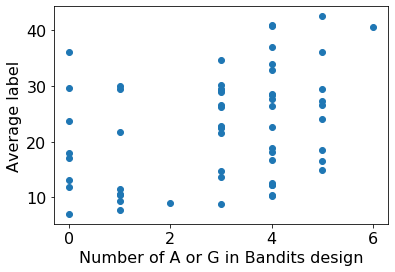

In [23]:
df_bandit = df[df['Group'] == 'bandit'][['RBS6', 'AVERAGE', 'STD']]
num_ags = []

for rbs6 in np.asarray(df_bandit['RBS6']):
    num = 0
    for i in rbs6:
        if i == 'A' or i == 'G':
            num+=1
    num_ags.append(num)
    
plt.scatter(num_ags, np.asarray(df_bandit['AVERAGE']))
plt.xlabel('Number of A or G in Bandits design')
plt.ylabel('Average label')

Text(0, 0.5, 'Number of sequences')

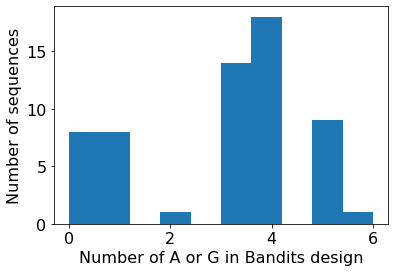

In [24]:
plt.hist(num_ags)
plt.xlabel('Number of A or G in Bandits design')
plt.ylabel('Number of sequences')

## Violinplot and swarmplot with AVERAGE value

In [25]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,80.91970,52.402431,98.72044,61.622165,54.151485,45.499195,65.552569,18.514648
47,48,RBS_1by1_48,bps_noncore,TTTAAGAAGGAGATAAACAT,AGGAGA,71.74603,43.377297,67.81084,49.202630,39.787620,40.075284,51.999950,12.996190
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,58.33688,40.072951,81.13620,42.042854,45.432032,41.005659,51.337763,14.673422
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,58.09954,45.913214,70.53162,44.352931,38.394865,43.641794,50.155661,10.883487
59,60,RBS_1by1_60,bps_noncore,TTTAAGAAGGAGATATACAA,AGGAGA,73.86549,43.183173,40.65514,47.433874,48.048028,45.612297,49.799667,11.051120
10,11,RBS_1by1_11,bps_noncore,TTTGAGAAGGAGATATACAT,AGGAGA,63.55034,44.897779,69.60175,42.063149,39.304470,38.642292,49.676630,12.244938
12,13,RBS_1by1_13,bps_noncore,TTTACGAAGGAGATATACAT,AGGAGA,58.07880,37.186557,76.09216,40.679528,33.421516,42.483442,47.990334,14.743561
11,12,RBS_1by1_12,bps_noncore,TTTTAGAAGGAGATATACAT,AGGAGA,65.10755,37.850634,76.23269,37.078370,32.308771,38.356101,47.822353,16.588524
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,60.72082,43.093359,74.60529,38.641958,38.049577,31.608154,47.786526,14.992992
7,8,RBS_1by1_8,bps_noncore,TTGAAGAAGGAGATATACAT,AGGAGA,57.18822,40.197744,NaN,45.233411,38.655693,44.862422,45.227498,6.506600


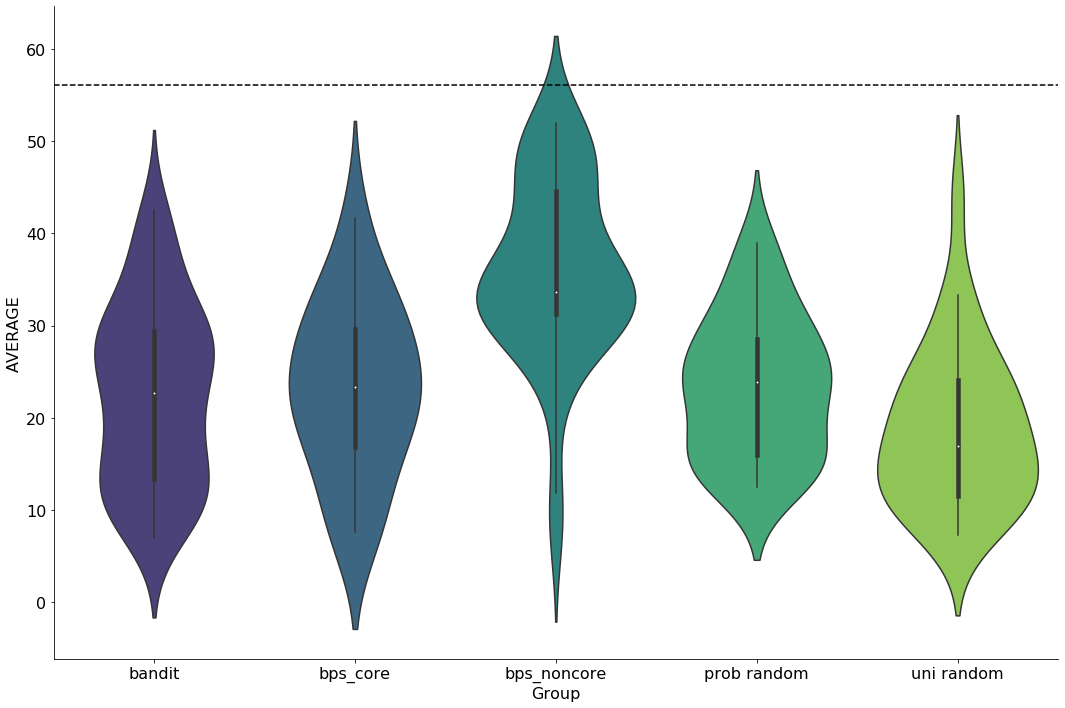

In [27]:
fig, ax = plt.subplots( figsize=(18,12))
plt.axhline(56.058,color="black",ls="--")
sns.violinplot(x="Group", y="AVERAGE", data=df.drop([0]).sort_values(by = ['Group'], ascending = True),palette='viridis')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#dfv = df.copy(deep=True)

#for index, row in dfv.iterrows():
#    if row['Group'] == 'bps' and row['RBS6'] == 'AGGAGA':
#        row['Group'] = 'bps_ncore'
#        dfv = dfv.append(row, ignore_index=True)
#    elif row['Group'] == 'bps' and row['RBS6'] != 'AGGAGA':
#        row['Group'] = 'bps_core'
#        dfv = dfv.append(row, ignore_index=True)      
        
#dfv.sort_values(by = ['Group'], ascending = True,inplace=True) 

#dfv.head(300)

#fig, ax = plt.subplots( figsize=(18,12))
#sns.violinplot(x="Group", y="AVERAGE", data=dfv,palette='viridis')

In [ ]:
fig, ax = plt.subplots( figsize=(18,12))
plt.axhline(56.058,color="black",ls="--")
sns.swarmplot(x="Group", y="AVERAGE", data=df.drop([0]),palette='plasma')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Violinplot with all replications

In [ ]:
df_all_rep = pd.melt(df, id_vars=['RBS', 'Group'], value_vars=['Rep1', 'Rep2', 'Rep3'])
df_all_rep = df_all_rep.dropna()

In [ ]:
df_all_rep.sort_values(by = ['value'], ascending = False).head(10)

In [ ]:
sns.violinplot(x="Group", y="value", data=df_all_rep)

## Predict labels with baseline data as training data

In [ ]:
df.sort_values(by = ['AVERAGE'], ascending = False).head(10)

In [ ]:
lm = sns.violinplot(x="Group", y="predict mean", data=df)
axes = lm.axes
axes.set_ylim(-2,4)

In [ ]:
sns.violinplot(x="Group", y="value", data=df_all_rep)